In [1]:
# GAN Used for training seismic data as part of Direct Diffraction Separation with Genarative Adversarial Networks
# Code by Brydon Lowney (2020)
# GAN portion of code was written with aid from machinelearningmastery.com

In [2]:
# Import modules used 

import numpy as np
import keras 
import os
import segpy as spy # to read in the segy data
import matplotlib.pyplot as plt
import datetime
import imageio
from segpy.reader import create_reader
from segpy.writer import write_segy
from PIL import Image

Using TensorFlow backend.


In [25]:
# Define parameters

SEGYFILENAME  = 'C:/Users/Python/Documents/PythonScripts/MachineLearning/GAN/GAN-master/SEISMIC/SEISMIC/WR332a-stack.sgy' # Put in your input segyfilename here
TRAINFILENAME = 'C:/Users/Python/Documents/PythonScripts/MachineLearning/GAN/GAN-master/SEISMIC/SEISMIC/WR332a-pwd.sgy' # Put in your training (target) segyfilename here
IMAGEDIR = 'C:/Users/Python/Documents/PythonScripts/MachineLearning/GAN/GAN-master/TESTIM/' # Put your desired image directory here make sure it ends in a /
MODELDIR = 'C:/Users/Python/Documents/PythonScripts/MachineLearning/GAN/GAN-master/TESTMOD/' # Put desired model directory here

In [14]:
# Load the raw data 

with open(SEGYFILENAME,'rb') as raw_in_file:
    
    t0 = datetime.datetime.now()
    
    raw_segy_dataset = create_reader(raw_in_file, endian='>')
    
    t1 = datetime.datetime.now()
    
    rawtracefull = []
    
    for trace_index in raw_segy_dataset.trace_indexes():
        rawtrace = raw_segy_dataset.trace_samples(trace_index)
        rawtracetemp = []
        for n in range(0,len(rawtrace)):
            temp = float(rawtrace[n])
            rawtracetemp.append(temp)
        rawtracefull.append(rawtracetemp)
    
    t2 = datetime.datetime.now()

In [15]:
# Check time to load 

time_for_header = (t1-t0).total_seconds()
time_for_traces = (t2-t1).total_seconds()
time_for_both = (t2-t0).total_seconds()

print('Time to read headers: {} seconds'.format(time_for_header))
print('Time to read traces: {} seconds'.format(time_for_traces))
print('Time to read both: {} seconds'.format(time_for_both))

Time to read headers: 1.007176 seconds
Time to read traces: 363.017292 seconds
Time to read both: 364.024468 seconds


In [20]:
# Load the training data 

with open(TRAINFILENAME,'rb') as train_in_file:
    
    t0 = datetime.datetime.now()
    
    train_segy_dataset = create_reader(train_in_file, endian='>')
    
    t1 = datetime.datetime.now()
    
    traintracefull = []
    
    for trace_index in train_segy_dataset.trace_indexes():
        traintrace = train_segy_dataset.trace_samples(trace_index)
        traintracetemp = []
        for n in range(0,len(traintrace)):
            temp = float(traintrace[n])
            traintracetemp.append(temp)
        traintracefull.append(traintracetemp)
    
    t2 = datetime.datetime.now()

In [21]:
# Check time to load training data 

time_for_header = (t1-t0).total_seconds()
time_for_traces = (t2-t1).total_seconds()
time_for_both = (t2-t0).total_seconds()

print('Time to read headers: {} seconds'.format(time_for_header))
print('Time to read traces: {} seconds'.format(time_for_traces))
print('Time to read both: {} seconds'.format(time_for_both))

Time to read headers: 3.155437 seconds
Time to read traces: 37.472568 seconds
Time to read both: 40.628005 seconds


In [22]:
# Convert the seismic to numpy array and rotate if necessary

rawtracefull = np.array(rawtracefull)
traintracefull = np.array(traintracefull)

print(rawtracefull.shape)
print(traintracefull.shape)

rawtracefull = np.rot90(rawtracefull, 3)
traintracefull = np.rot90(traintracefull, 3)

print(rawtracefull.shape)
print(traintracefull.shape)

(4896, 5500)
(4896, 5500)
(5500, 4896)
(5500, 4896)


In [23]:
# Make the size divisible by 256 so we don't lose any data 

seismic_size = rawtracefull.shape
seismic_y = seismic_size[0]
seismic_x = seismic_size[1]

mult_y = np.ceil(seismic_y/256)
mult_x = np.ceil(seismic_x/256) # ceiling is used so it always rounds up

mult_y = int(mult_y)
mult_x = int(mult_x)

new_y = mult_y*256
new_x = mult_x*256

newtraining = np.zeros((new_y,new_x))
newseismic = np.zeros((new_y,new_x))
newseismic[0:seismic_y,0:seismic_x] = rawtracefull
newtraining[0:seismic_y,0:seismic_x] = traintracefull

print(seismic_size)
print(np.shape(newseismic))
print(np.shape(newtraining))

(5500, 4896)
(5632, 5120)
(5632, 5120)


In [28]:
# Make directories for the 256 x 256 size data for testing and save

traindir = os.path.join(IMAGEDIR,'train/')
styledir = os.path.join(IMAGEDIR,'style/')

if not os.path.exists(traindir):
    os.mkdir(traindir)
if not os.path.exists(styledir):
    os.mkdir(styledir)

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        raw_256 = newseismic[y:y+256,x:x+256] 
        sty_256 = newtraining[y:y+256,x:x+256]

        filenumber_y = str(y)
        filenumber_x = str(x)

        plt.imsave('{}train_y{}_x{}.png'.format(traindir, filenumber_y.zfill(5), filenumber_x.zfill(5)), raw_256, vmin=-5, vmax=5, cmap='Greys')
        plt.imsave('{}style_y{}_x{}.png'.format(styledir, filenumber_y.zfill(5), filenumber_x.zfill(5)), sty_256, vmin=-1, vmax=1, cmap='Greys')



In [29]:
# Reload seismic but as an image 

src_filelist = []
tar_filelist = []

for y in range(0,(new_y-256),256):
    for x in range(0,(new_x-256),256):
        
        filenumber_y = str(y)
        filenumber_x = str(x)

        src_filelist.append('{}train_y{}_x{}.png'.format(traindir, filenumber_y.zfill(5), filenumber_x.zfill(5)))
        tar_filelist.append('{}style_y{}_x{}.png'.format(styledir, filenumber_y.zfill(5), filenumber_x.zfill(5)))
        
src_images = np.array([np.array(Image.open(fname)) for fname in src_filelist])
tar_images = np.array([np.array(Image.open(fname)) for fname in tar_filelist])

src_images = src_images[:,:,:,0:3]
tar_images = tar_images[:,:,:,0:3]

np.shape(src_images)
np.shape(tar_images)

(399, 256, 256, 3)

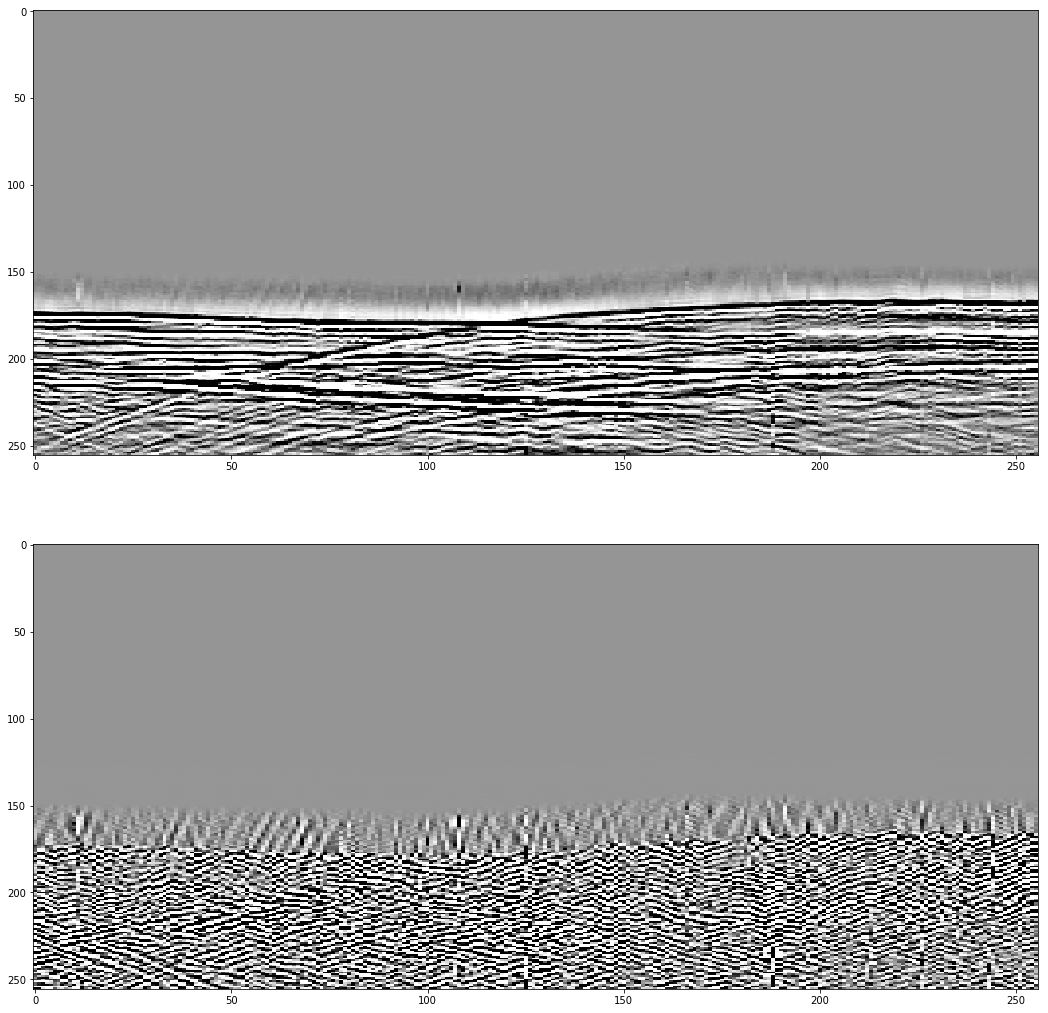

In [31]:
# View the 2 datasets as a check (will need to make sure this is single IL on a 3D example)

test_img = np.shape(src_images)
test_img = np.round(test_img[0]/2)
test_img = int(test_img)

fig, axes = plt.subplots(2, 1, figsize=(18, 18))
axes[0].imshow(src_images[test_img], cmap='Greys', aspect='auto')
axes[1].imshow(tar_images[test_img], cmap='Greys', aspect='auto')
#plt.colorbar()
plt.show()

In [32]:
# Save as compressed numpy array 

arrayfilename = '{}training_256.npz'.format(IMAGEDIR)
np.savez_compressed(arrayfilename, src_images, tar_images)


In [33]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (3,3), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (3,3), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [34]:
# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [35]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

In [36]:
# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [37]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [38]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [39]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	modeldir = os.path.join(MODELDIR,'models/')
	plotsdir = os.path.join(MODELDIR,'plots/')
	if not os.path.exists(modeldir):
		os.mkdir(modeldir)
	if not os.path.exists(plotsdir):
		os.mkdir(plotsdir)    
	filename1 = '{}plot_%06d.png'.format(plotsdir) % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '{}model_%06d.h5'.format(modeldir) % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

In [40]:
# train pix2pix model
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# load image data
dataset = load_real_samples(arrayfilename)
#dataset = [src_images, tar_images]
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
# train model
train(d_model, g_model, gan_model, dataset)

Loaded (399, 256, 256, 3) (399, 256, 256, 3)
